# **EMNIST character Recognization**

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from torchvision import transforms, datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Agnoistic device for computation: {device}')

Agnoistic device for computation: cuda


In [3]:
# data_transform = transforms.Compose([
#     transforms.ToTensor()
# ])

In [4]:
# Define the transformation to be applied to the data
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.EMNIST(root='train',       # root directory of the dataset
                                train=True,         # use the training set
                                download=True,      # download the dataset if it doesn't exist
                                split='letters',    # use the letters portion of the dataset
                                transform=transform, # apply the defined transformation
                                target_transform=None) # don't apply any transformation to the labels

# Load the test dataset
test_dataset = datasets.EMNIST(root='test',        # root directory of the dataset
                                train=False,        # use the test set
                                download=True,      # download the dataset if it doesn't exist
                                split='letters',    # use the letters portion of the dataset
                                transform=transform, # apply the defined transformation
                                target_transform=None) # don't apply any transformation to the labels

100%|██████████| 561753746/561753746 [00:44<00:00, 12674706.22it/s]


Extracting train/EMNIST/raw/gzip.zip to train/EMNIST/raw


100%|██████████| 561753746/561753746 [00:43<00:00, 13045965.92it/s]


Extracting test/EMNIST/raw/gzip.zip to test/EMNIST/raw


In [5]:
classes = train_dataset.classes
classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [6]:
# Get the first image and label from the training dataset
image, label = train_dataset[0]

# Print the shape of the image and label
print(f'image shape: {image.shape}')
print(f'label shape: {label}')

# Print a separator
print('*'*50)

# Print the number of samples in the training and test datasets
print(f'Total Training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print a separator
print('*'*50)

# Print the class labels for the dataset
print(f'Labels are: {train_dataset.classes}')


image shape: torch.Size([1, 28, 28])
label shape: 23
**************************************************
Total Training samples: 124800
Total testing samples: 20800
**************************************************
Labels are: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


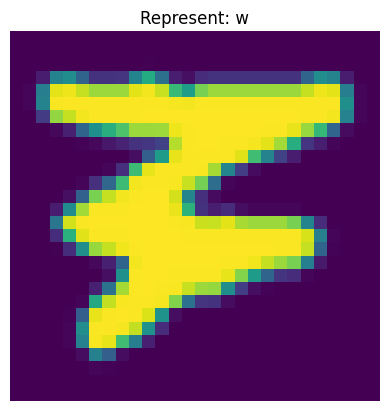

In [7]:
# Permute the dimensions of the image tensor to (channels, height, width)
image_for_plot = image.permute(1, 2, 0)

# Use matplotlib to display the image
plt.imshow(image_for_plot.squeeze())  # remove the singleton dimensions from the tensor
plt.title(f'Represent: {classes[label]}')  # set the title using the label and the class labels
plt.axis(False)  # hide the axis
plt.show()  # show the plot


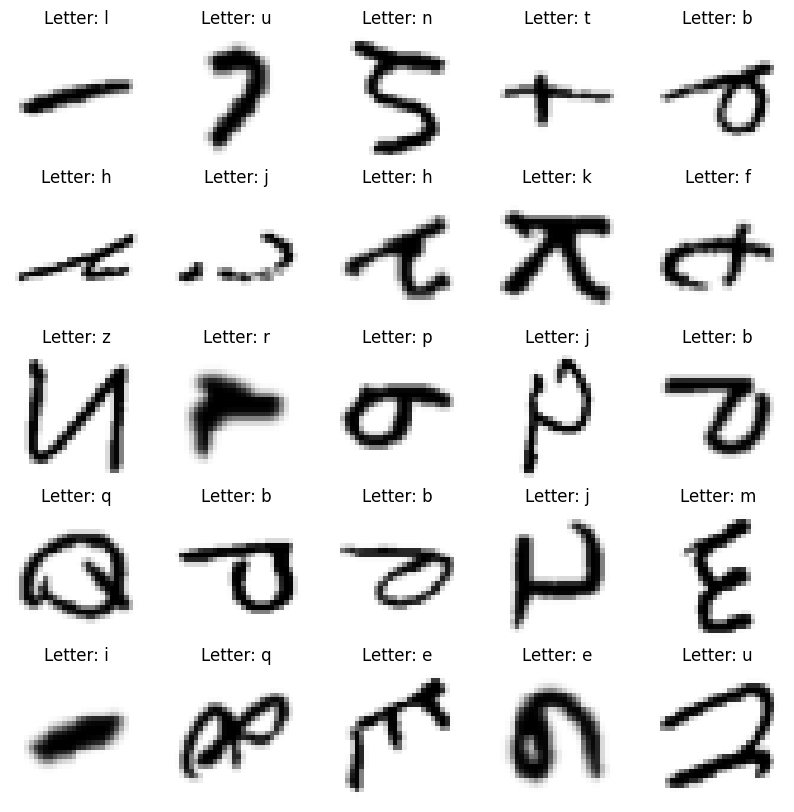

In [8]:
# Set the number of rows and columns for the plot
ROWS = 5
COLUMNS = 5

# Set the random seed for reproducibility
torch.manual_seed(42)

# Generate a sequence of 25 random indices
random_index = torch.randint(low=0, high=len(train_dataset), size=(25,))

# Create a figure with a specified size
plt.figure(figsize=(10, 10))

# Iterate over the indices and plot the images
for i in range(ROWS*COLUMNS):
  # Get the image and label for the current index
  train_sample, train_sample_label = train_dataset[random_index[i]]

  # Create a subplot for the current image
  plt.subplot(ROWS, COLUMNS, i+1)
  plt.title(f'Letter: {classes[train_sample_label]}')  # set the title using the label and the class labels
  plt.imshow(train_sample.squeeze(), cmap=plt.cm.binary)  # display the image
  plt.axis(False)

In [9]:
# Set the batch size for the data loaders
BATCH_SIZE = 32

# Create a DataLoader for the training dataset
train_data = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        pin_memory=True)

# Create a DataLoader for the test dataset
test_data = DataLoader(test_dataset,
                       batch_size=len(test_dataset),
                       pin_memory=True)

In [10]:
# Get the first batch of training and test data
X_train, y_train = next(iter(train_data))
X_test, y_test = next(iter(test_data))

# Print the shapes and devices of the training and test data
print(f'X train shape: {X_train.shape} and device: {X_train.device}')
print(f'X test shape: {X_test.shape} and device: {X_test.device}')
print(f'y train shape: {y_train.shape} and device: {y_train.device}')
print(f'y test shape: {y_test.shape} and device: {y_test.device}')

# Print the number of batches and the total number of samples in the training and test datasets
print(f'{len(train_data)} batches are available for {len(train_dataset)} train samples')
print(f'{len(test_data)} batches are available for {len(test_dataset)} test samples')

X train shape: torch.Size([32, 1, 28, 28]) and device: cpu
X test shape: torch.Size([20800, 1, 28, 28]) and device: cpu
y train shape: torch.Size([32]) and device: cpu
y test shape: torch.Size([20800]) and device: cpu
3900 batches are available for 124800 train samples
1 batches are available for 20800 test samples


In [11]:
class EMINSTClassificationModelV0(nn.Module):
  def __init__(self,
               input_shape,  # size of the input data
               hidden_units, # number of hidden units in the model
               output_shape): # size of the output data
    super().__init__()

    # Create a Sequential model consisting of a series of linear and ReLU layers
    self.linear_stack = nn.Sequential(
        nn.Flatten(),  # flatten the input data into a 1D tensor
        nn.Linear(in_features=input_shape, out_features=hidden_units),  # linear layer with hidden_units output units
        nn.ReLU(),  # ReLU activation function
        nn.Linear(in_features=hidden_units, out_features=hidden_units),  # linear layer with hidden_units output units
        nn.ReLU(),  # ReLU activation function
        nn.Linear(in_features=hidden_units, out_features=output_shape)  # linear layer with output_shape output units
    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    # Apply the sequence of linear and ReLU layers to the input data
    return self.linear_stack(x)

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model
model0 = EMINSTClassificationModelV0(input_shape=28*28,
                                     hidden_units=128,
                                     output_shape=len(classes))
model0.to(device)
print(f'Model device: {next(model0.parameters()).device} and dtype: {next(model0.parameters()).device}')

Model device: cuda:0 and dtype: cuda:0


In [12]:
# Create a loss function for the model
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for the model
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [13]:
# Generate dummy data and labels
dummy_data = torch.rand(64, 1, 28, 28).to(device)
dummy_label = torch.from_numpy(np.random.randint(low=0, high=27, size=64)).to(device)

# Print the shapes of the dummy data and labels
print(f'Shape of dummy data: {dummy_data.shape} \nShape of dummy labels: {dummy_label.shape}')

# Uncomment the following lines to visualize the dummy data
# plt.imshow(dummy_data.squeeze())
# plt.axis(False)
# plt.show()

Shape of dummy data: torch.Size([64, 1, 28, 28]) 
Shape of dummy labels: torch.Size([64])


In [14]:
# Enter inference mode
with torch.inference_mode():
  # Generate predictions using the model
  y_preds = model0(dummy_data)
  print(f'Shape of predictions: {y_preds.shape}')
  print(f'Predictions: {y_preds}')

  # Calculate the loss using the loss function
  loss = loss_fn(y_preds, dummy_label)
  print(f'Loss: {loss}')

  # Apply the softmax function to the predictions to get the predicted class probabilities
  y_preds_probs = torch.softmax(y_preds, dim=1)
  print(f'Predicted class probabilities: {y_preds_probs}')

  # Get the predicted class labels by taking the argmax of the class probabilities
  y_preds_label = y_preds_probs.argmax(dim=1)
  print(f'Predicted class labels: {y_preds_label}')

Shape of predictions: torch.Size([64, 27])
Predictions: tensor([[-0.0997, -0.0930, -0.0343,  ...,  0.0726, -0.0984,  0.0682],
        [-0.0651, -0.0931, -0.0251,  ...,  0.0699, -0.1202,  0.1306],
        [-0.0862, -0.0759,  0.0134,  ...,  0.0722, -0.1326,  0.1142],
        ...,
        [-0.0655, -0.0440,  0.0603,  ...,  0.0634, -0.1022,  0.1721],
        [-0.0837, -0.0452,  0.0270,  ...,  0.0172, -0.1030,  0.1017],
        [-0.0497, -0.0478, -0.0129,  ...,  0.0725, -0.1287,  0.1414]],
       device='cuda:0')
Loss: 3.299755096435547
Predicted class probabilities: tensor([[0.0335, 0.0337, 0.0357,  ..., 0.0398, 0.0335, 0.0396],
        [0.0350, 0.0341, 0.0365,  ..., 0.0401, 0.0332, 0.0426],
        [0.0342, 0.0346, 0.0378,  ..., 0.0401, 0.0327, 0.0418],
        ...,
        [0.0345, 0.0352, 0.0391,  ..., 0.0392, 0.0332, 0.0437],
        [0.0343, 0.0356, 0.0383,  ..., 0.0379, 0.0336, 0.0413],
        [0.0352, 0.0353, 0.0365,  ..., 0.0398, 0.0325, 0.0426]],
       device='cuda:0')
Predicted

In [15]:
def accuracy_fn(y_true: torch.Tensor, y_preds: torch.Tensor) -> float:
    """
    Calculate the accuracy of predictions.

    Args:
        y_true (torch.Tensor): The true labels.
        y_preds (torch.Tensor): The predicted labels.

    Returns:
        float: The accuracy of the predictions.
    """
    count = torch.eq(y_true, y_preds).sum().item()
    acc = count / len(y_preds)
    return acc


In [16]:
# Initialize lists to track loss and accuracy during training and testing
track_test_loss, track_train_loss = [], []
track_test_acc, track_train_acc = [], []
epoch_count = []

# Set the number of epochs
epochs = 10

# Use tqdm to display a progress bar
for epoch in tqdm(range(epochs)):
  # Initialize variables to store loss and accuracy
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0, 0

  # Put the model in training mode
  model0.train()

  # Loop through the training data in batches
  for batch, (X, y) in enumerate(train_data):
    # Move the data and labels to the device
    X, y = X.to(device), y.to(device)

    # Generate predictions and calculate the loss
    y_logits = model0(X)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y)

    # Update the running totals for loss and accuracy
    train_acc += accuracy_fn(y_true=y, y_preds=y_preds)
    train_loss += loss

    # Zero the gradients and perform the backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculate the average loss and accuracy for the epoch
  train_loss /= batch
  train_acc /= batch

  model0.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_data):
      X, y = X.to(device), y.to(device)

      # print(f'X test shape: {X.shape} and y test shape: {y.shape}')
      test_logits = model0(X)
      t_loss = loss_fn(test_logits, y)
      test_loss += t_loss
      test_preds = torch.softmax(test_logits.squeeze(), dim=1).argmax(dim=1)
      test_acc += accuracy_fn(y_true=y, y_preds=test_preds)

  # print(test_loss, batch)
  test_loss = test_loss
  if epoch % 2 == 0:
    print(f"Epoch: {epoch} | train_loss: {train_loss: .3f} | test_loss: {test_loss: .3f} | train-acc: {train_acc: .3f} | test_acc: {test_acc: .3f}")
    epoch_count.append(epoch)
    track_train_acc.append(train_acc)
    track_train_loss.append(train_loss.clone().detach().requires_grad_(False))
    track_test_acc.append(test_acc)
    track_test_loss.append(test_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train_loss:  0.813 | test_loss:  0.473 | train-acc:  0.754 | test_acc:  0.851
Epoch: 2 | train_loss:  0.323 | test_loss:  0.349 | train-acc:  0.896 | test_acc:  0.889
Epoch: 4 | train_loss:  0.263 | test_loss:  0.338 | train-acc:  0.912 | test_acc:  0.895
Epoch: 6 | train_loss:  0.229 | test_loss:  0.307 | train-acc:  0.921 | test_acc:  0.903
Epoch: 8 | train_loss:  0.206 | test_loss:  0.320 | train-acc:  0.928 | test_acc:  0.904


In [17]:
transfer_to_cpu = lambda x: [tensor.cpu() for tensor in x]

In [18]:
track_test_loss

[tensor(0.4734, device='cuda:0'),
 tensor(0.3487, device='cuda:0'),
 tensor(0.3383, device='cuda:0'),
 tensor(0.3072, device='cuda:0'),
 tensor(0.3197, device='cuda:0')]

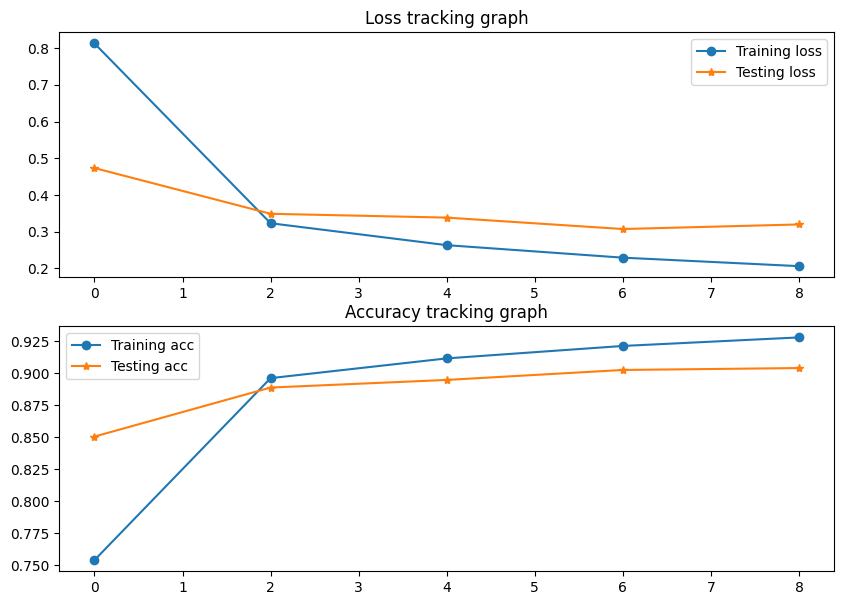

In [19]:
# Set the figure size and create subplots
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)

# Set the title and plot the training and testing loss
plt.title('Loss tracking graph')
plt.plot(epoch_count, transfer_to_cpu(track_train_loss), 'o-', label='Training loss')
plt.plot(epoch_count, transfer_to_cpu(track_test_loss), '*-', label='Testing loss')

# Add a legend
plt.legend()

# Create the second subplot for the accuracy tracking
plt.subplot(2,1,2)

# Set the title and plot the training and testing accuracy
plt.title('Accuracy tracking graph')
plt.plot(epoch_count, track_train_acc, 'o-', label='Training acc')
plt.plot(epoch_count, track_test_acc, '*-', label='Testing acc')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [20]:
y_preds.shape, y.shape

(torch.Size([32]), torch.Size([20800]))

In [21]:
np.unique(classes), np.unique(y_preds.cpu())

(array(['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
        'z'], dtype='<U3'),
 array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 12, 14, 15, 17, 19, 20, 21, 23,
        25]))

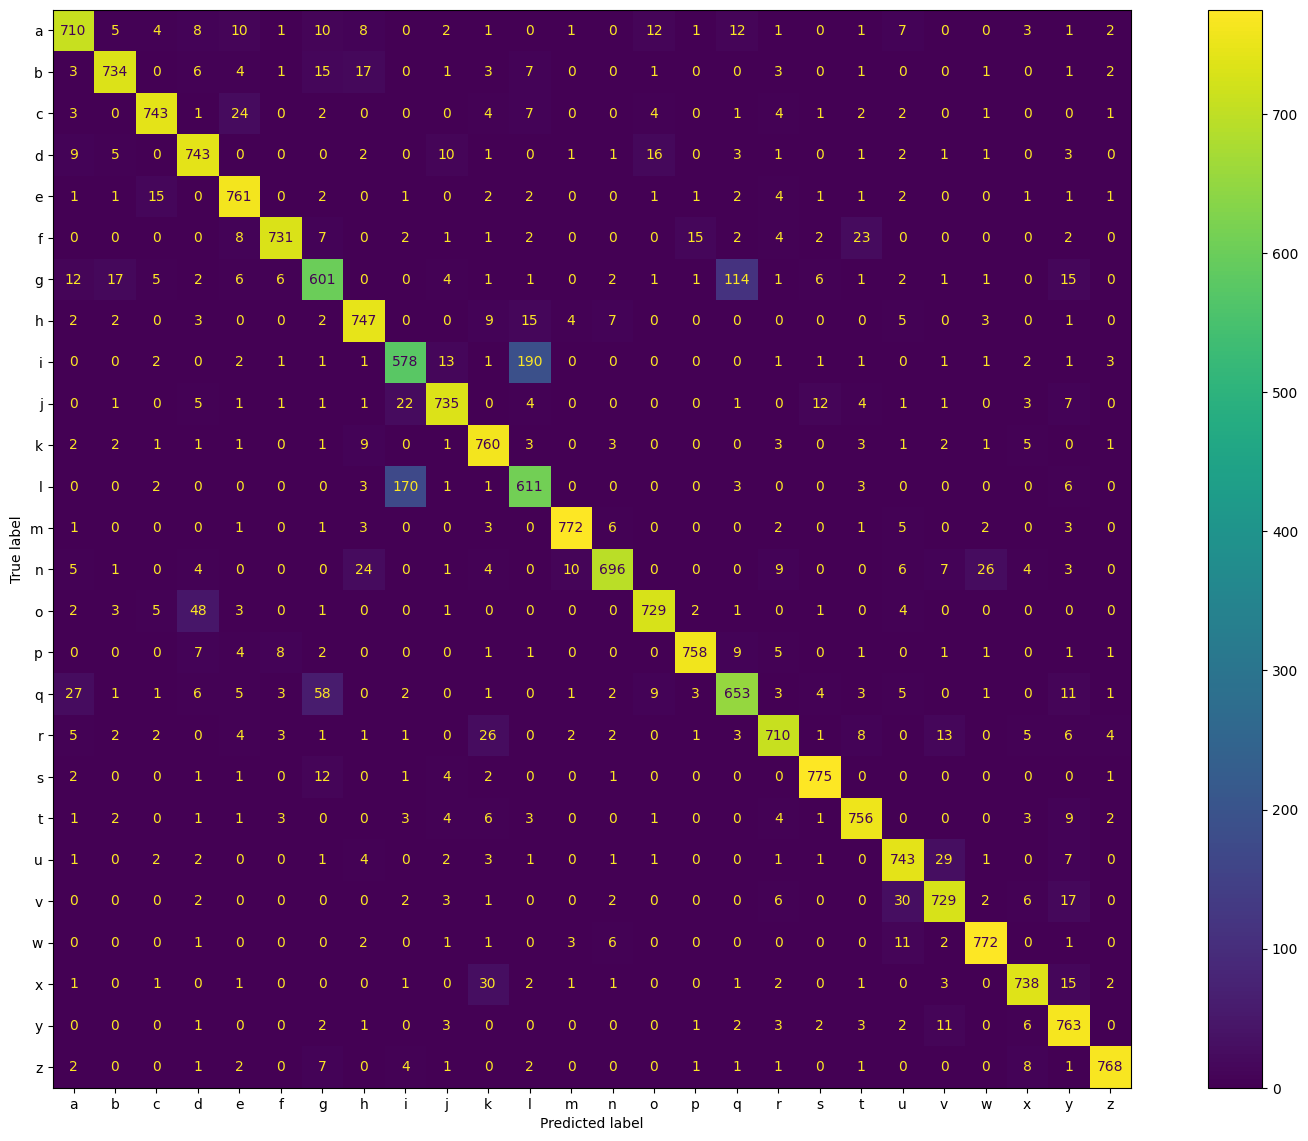

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y.cpu(), test_preds.cpu(), display_labels=classes[1:])
fig = disp.figure_
fig.set_figheight(14)
fig.set_figwidth(20)
plt.show()